In [3]:
#http://www.yisongyue.com/publications/cvpr2016_online_smooth.pdf

ws_mode = "off"
test_mode = "full" # or full
dataset = "basket" # or soccer or basket

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib.font_manager import FontProperties
if ws_mode is "on":
    plt.switch_backend('agg') #turn on for workstation
from operator import itemgetter
from itertools import groupby
from sklearn import tree
from sklearn import ensemble
import time
from sklearn import linear_model
import math
import sys
import subprocess
import copy

#sys.path.append('.')
from smoothing_helpers import *

if 'darwin' in sys.platform:
    print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
    subprocess.Popen('caffeinate')

fontP = FontProperties()
fontP.set_size('small')

 ###### SETTING UP PARAMETERS
regularize_method = "diff_pos_diff_res" #could be diff_pos_diff_res, or "pos_red"

tao = 10
beta_trend = 0.0
beta_fixed = 0.1
no_iter = 15
alpha_reg = 750
no_tree = 10
smooth_weight = 50
expert_feedback = "human" 
smooth_method = "stack_pos_proper"  
explore_strategy = "interpolated" # or new

rollout_coeff = "humanc" # or expertc
# let's add method stack_pos_proper
#either stack_pos, stack_pos_vel, stack_vel_pos, stack_pos_res, no_stack, predict_pos_res

res_reg = 1000 # note usually set for small like 0.5
smooth_weight_vector = np.linspace(smooth_weight,smooth_weight,no_iter+1)
smooth_weight_vector[0] = 500
train_error_vector = np.zeros(smooth_weight_vector.shape)
test1_error_vector = np.zeros(smooth_weight_vector.shape)
test2_error_vector = np.zeros(smooth_weight_vector.shape)
split_weight = smooth_weight
#smooth_weight_vector = smooth_weight_vector[::-1]
#smooth_weight_vary = np.arange(150,150, no_iter)
decay_factor = 1.6
expert_smooth_weight = np.linspace(0.2,decay_factor,no_iter)
joinLossPenalize = 0 # ignore smoothloss for the error calculation, leave to policy class
depth = 10
leaf = 32
residual_method = "external"

node_split = "feature_dependent_mse" #either "feature_dependent_mse" or just "mse" the default

if smooth_method is "stack_pos":
    roll_method = "Raw"
elif smooth_method is "stack_pos_proper":
    roll_method = "Prop"
else:
    roll_method = "sthElse"
state_method = smooth_method #either stack_pos, stack_pos_vel, stack_vel_pos

#expert_smooth_weight = expert_smooth_weight[::-1]
output_name = test_mode + str(expert_feedback)+"_roll"+roll_method+"_avg_diff_tao10_posOnly"+str(alpha_reg)+"_sw"+str(smooth_weight)+"_tree"+str(no_tree)+"_beta"+str(beta_fixed)+"_explore"+explore_strategy+rollout_coeff+"_"
#output_name = "searnOut_rf100_tao10_sw200_changeC_iter12_alpha750_jointLoss_sqrtFeatures_betaAdapt_decay053.pdf"
#output_name = "cutoff50k_rf30_sw200_reg5000_tau10_decay0208_mseLoss_sqrt_posres_"
#output_name = "output_soccer.pdf"
#pdf = matplotlib.backends.backend_pdf.PdfPages(output_name) #turn on for workstation
beta_vector = np.zeros(no_iter)

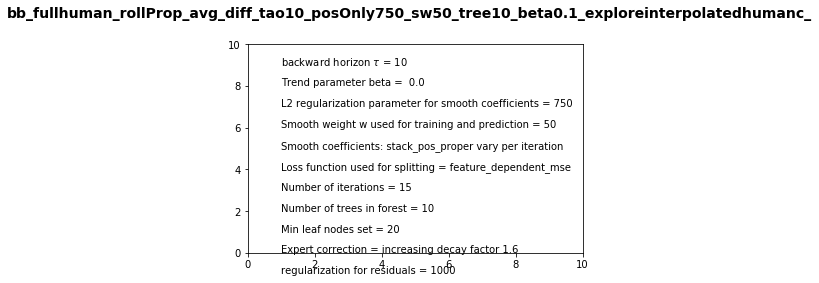

FileNotFoundError: [Errno 2] No such file or directory: 'SPM_33_train.txt'

In [8]:
## Plot a figure to save parameters used
%matplotlib inline
fig = plt.figure()
fig.suptitle('bb_'+output_name, fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.text(1,9,r'backward horizon $\tau$ = '+ str(tao)) 
ax.text(1,8,'Trend parameter beta =  '+ str(beta_trend)) 
ax.text(1,7,'L2 regularization parameter for smooth coefficients = '+ str(alpha_reg)) 
ax.text(1,6,'Smooth weight w used for training and prediction = '+ str(smooth_weight)) 
ax.text(1,5,'Smooth coefficients: '+ smooth_method +' vary per iteration') 
ax.text(1,4,'Loss function used for splitting = '+ node_split ) 
ax.text(1,3,'Number of iterations = '+ str(no_iter))
ax.text(1,2,'Number of trees in forest = '+ str(no_tree))
ax.text(1,1,'Min leaf nodes set = '+ str(20))
ax.text(1,0,'Expert correction = increasing decay factor '+ str(decay_factor))
ax.text(1,-1,'regularization for residuals = '+ str(res_reg)) 
ax.axis([0, 10, 0, 10])
if ws_mode is "off":
    plt.show() # turn off for work station
#pdf.savefig(fig) #turn on for workstation

####### READ DATA - Camera Data
if dataset is "basket":
    trainData = np.loadtxt('SPM_33_train.txt', dtype = 'float', skiprows = 1) #basketball
elif dataset is "soccer":
    trainData = np.loadtxt('spm_soccer_train.txt', dtype = 'float', skiprows = 1) #soccer
### Manually select a portion of the train data to play around with
if test_mode is "cutoff":
    cutoff = 50000 # change for workstation
    data = trainData[0:cutoff,:]
else:
    data = trainData # flip this back when done testing
if dataset is "basket":
    testData = np.loadtxt('SPM_33_test_2006.txt', dtype = 'float', skiprows = 1)
    testData2 = np.loadtxt('SPM_33_test_4020.txt', dtype = 'float', skiprows = 1)
elif dataset is "soccer":
    testData2 = np.loadtxt('spm_soccer_test_44.txt', dtype = 'float', skiprows = 1) #soccer
    testData = np.loadtxt('spm_soccer_test_108.txt', dtype = 'float', skiprows = 1) #soccer
trainFrame = data[:,0]
trainFrame = trainFrame.astype(int)

# Group consecutive frames into different segments of play
inPlay = [] #lis tof tuples. Each element in the list is a pair of indices, the beginning and ending index of a segment
for k, g in groupby(enumerate(trainFrame), lambda i,x:i-x):
    group = map(itemgetter(0), g)
    inPlay.append((group[0], group[-1]))

segment = [] #list of np array. each element in the list is an array of consecutive frames

for item in inPlay:
    #print item[1]-item[0]+1
    play = data[item[0]:(item[1]+1),1:]
    segment.append(play)

human = data[:,1]
game_context = data[:,2:]
number_of_feature = game_context.shape[1] #it is better to have number of features directly infered from X

###### SET UP TESTING DATA
game_context_test = testData[:,2:]
human_test = testData[:,1]

testFrame = testData[:,0]
testFrame = testFrame.astype(int)
testFrame = testFrame - min(testFrame) +1

game_context_test2 = testData2[:,2:]
human_test2 = testData2[:,1]

testFrame2 = testData2[:,0]
testFrame2 = testFrame2.astype(int)
testFrame2 = testFrame2 - min(testFrame2) +1

# Build auroregressed matrix for test values of X
autoreg_game_context_test = game_context_test.copy()
for i in range(tao):
    temp = np.roll(game_context_test,(i+1)*number_of_feature)
    for j in range(i+1):
        temp[j] = 0
    autoreg_game_context_test = np.hstack((autoreg_game_context_test,temp))

autoreg_game_context_test2 = game_context_test2.copy()
for i in range(tao):
    temp = np.roll(game_context_test2,(i+1)*number_of_feature)
    for j in range(i+1):
        temp[j] = 0
    autoreg_game_context_test2 = np.hstack((autoreg_game_context_test2,temp))

In [ ]:

####### CALCULATE SMOOTH COEFFICIENTS
# Smooth velocity calculations
# Let's figure out the smooth thing here

human_smooth_coeff = velocity_smooth(human,alpha_reg, tao)
print "Coeff soly based on velocity"
print human_smooth_coeff

###### BUILD AUGMENTED FEATURE VECTORS 
autoreg_game_context = form_augmented_context_train(game_context, tao)
old_learned_trajectory = human.copy()
loop_count = 0
smooth_weight = smooth_weight_vector[loop_count]


###### LEARN INITIAL POLICY:

explore_trajectory = human.copy()
expert_recs = explore_trajectory.copy() 
old_smooth_coeff = calculate_smooth_coeff(expert_recs, alpha_reg, tao, smooth_method) #reactivate this

aux_position = form_auxiliary_position_vector(explore_trajectory, tao)
state_vectors = np.hstack((autoreg_game_context,aux_position))
rows_to_delete = gather_rows_to_delete(tao)
n_smooth_features = tao
old_policy = ensemble.RandomForestRegressor(n_estimators = no_tree, criterion = node_split,n_smooth_features = n_smooth_features, max_features = 'sqrt', min_samples_leaf = leaf,
                                smooth_coeff = old_smooth_coeff, smooth_weight = split_weight)
#Truncate the first 2*tau frames of each segment to make sure the data to fit is pure
state_vectors_fit = np.delete(state_vectors, rows_to_delete, 0)
expert_recs_fit = np.delete(expert_recs, rows_to_delete, 0)
old_policy = old_policy.fit(state_vectors_fit,expert_recs_fit)

old_learned_trajectory = roll_and_smooth_learned_trajectory(old_policy, old_smooth_coeff, smooth_weight, smooth_method)
Y_test1 = roll_and_smooth_test_trajectory(old_policy, human_test, autoreg_game_context_test, old_smooth_coeff, smooth_weight, smooth_method)
Y_test2 = roll_and_smooth_test_trajectory(old_policy, human_test2, autoreg_game_context_test2, old_smooth_coeff, smooth_weight, smooth_method)

# Plot initial policy
if dataset is "basket":
    item = inPlay[5]
elif dataset is "soccer":
    item = (30000, 40000)
fig = plt.figure()
plt.plot(trainFrame[item[0]:item[1]],human[item[0]:item[1]],'b', label = 'Actual Y')
plt.plot(trainFrame[item[0]:item[1]],explore_trajectory[item[0]:item[1]],'m', label = 'Explore')
plt.plot(trainFrame[item[0]:item[1]],expert_recs[item[0]:item[1]],'r', label = 'Expert')
plt.plot(trainFrame[item[0]:item[1]],old_learned_trajectory[item[0]:item[1]],'g', label = 'Learned')

plt.title("Initial Policy Plot")
plt.xlabel("Frame number")
plt.ylabel("Y Values")
plt.legend(loc = "lower right", ncol=2, prop = fontP)
if ws_mode is "off":
    plt.show() #turn off for workstation
#pdf.savefig(fig) #turn on for workstation

trainError = math.sqrt(np.mean((human-old_learned_trajectory)**2))
# Plot testing performance
testError = math.sqrt(test_error_calculation(human_test, Y_test1, joinLossPenalize))    
print ("Plot of the test set 1")
fig = plt.figure()
plt.plot(testFrame,human_test,'b', label = 'ground truth')
plt.plot(testFrame,Y_test1,'r',label = 'filtered predicted')
plt.title("jointloss "+ str(testError))
plt.xlabel("frame number")
plt.ylabel("pan angle (degrees)")
plt.legend(loc = "lower right", ncol =2, prop=fontP)
if ws_mode is "off":
    plt.show() #turn off for workstation
#pdf.savefig(fig) #turn on for workstation

testError2 = math.sqrt(test_error_calculation(human_test2, Y_test2, joinLossPenalize))  
print ("Plot of the test set 2 ")
fig = plt.figure()
plt.plot(testFrame2,human_test2,'b', label = 'ground truth')
plt.plot(testFrame2,Y_test2,'r',label = 'filtered predicted')
plt.title("jointloss "+ str(testError2))
plt.xlabel("frame number")
plt.ylabel("pan angle (degrees)")
plt.legend(loc = "lower right", ncol =2, prop=fontP)
#plt.savefig(test2_name, format = 'png')
if ws_mode is "off":
    plt.show() #turn off for workstation

#save error of training and testing
train_error_vector[0] = trainError
test1_error_vector[0] = testError
test2_error_vector[0] = testError2

#### MAIN LOOP OF TRAINING

# First initialize learned policy for exploration
learned_trajectory = old_learned_trajectory.copy()
explore_trajectory = learned_trajectory.copy()

#old_train_error = math.sqrt(((learned_trajectory-human)**2).mean())
old_train_error = joint_loss_calculation(human, old_learned_trajectory, joinLossPenalize)
print "Initial train error"
print old_train_error

train_file = "0201bb_"+dataset+"_train_"+output_name+"loop_"
test1_file = "0201bb_"+dataset+"_test1_"+output_name+"loop_"
test2_file = "0201bb_"+dataset+"_test2_"+output_name+"loop_"
error_file = "0201beta_"+dataset+output_name+".txt"

#hoang Dec 4: plot iteration 0 for NIPS workshop
test1_name = test1_file+str(loop_count)+".txt"
if test_mode is "full":
    np.savetxt(test1_name, Y_test1)

test2_name = test2_file+str(loop_count)+".txt"
if test_mode is "full":
    np.savetxt(test2_name, Y_test2)
#hoang Dec 4: end savinf iteration 0 for NIPS workshop

while (loop_count < no_iter):
    loop_count = loop_count + 1
    smooth_weight = smooth_weight_vector[loop_count]

    print ("This is the plot of iteration number ", loop_count)
    # make plot of current training progress 
    
    ## Line below is a mistake if averaging models, instead just set explore to the new learned trajectory

    if expert_feedback is "expert":
        expert_recs = np.zeros(explore_trajectory.shape)
        for item in inPlay:
            for index in np.arange(item[0],item[0]+tao):
                expert_recs[index] = human[index] 
            for index in np.arange(item[0]+tao,item[1]+1): 
                #previous_prediction = Y_hat_seg[index-tao:index]
                previous_prediction = explore_trajectory[index-tao:index].copy()
                previous_prediction = previous_prediction[::-1]
    #            expert_recs[index] =(human[index]+np.inner(position_smooth_coeff,
    #                                       previous_prediction)*smooth_weight) / (1+smooth_weight)
                #expert_recs[index] =(human[index]+np.inner(position_smooth_coeff,
                #                           previous_prediction)*expert_smooth_weight[loop_count-1]) / (1+expert_smooth_weight[loop_count-1])                                           
                #expert_recs[index] = human[index]+ math.exp(-1*decay_factor)*(explore_trajectory[index]-human[index])
                expert_recs[index] = human[index]+ math.exp(-1*expert_smooth_weight[loop_count-1])*(explore_trajectory[index]-human[index]) # exponential method used for nips
                #expert_recs[index] = human[index]+ math.exp(-1*expert_smooth_weight[loop_count-1])*(human[index]-explore_trajectory[index]) # try: overshoot intentionally
                #expert_recs[index] = human[index] - human[index-tao] + explore_trajectory[index-tao] # try: maintain a parallel line
    
    # to comment out the next line - test to see what happens if we just set expert recs to be human
    elif expert_feedback is "human":
        expert_recs = human.copy()

    new_smooth_coeff = calculate_smooth_coeff(expert_recs, alpha_reg, tao, smooth_method) # reactive this, velocity based fit

    print "New position coefficient is"
    print new_smooth_coeff
    
    aux_position = form_auxiliary_position_vector(explore_trajectory, tao)
    state_vectors = np.hstack((autoreg_game_context,aux_position))

    # Update the model
    new_policy = ensemble.RandomForestRegressor(n_estimators = no_tree, criterion = node_split,n_smooth_features = n_smooth_features, max_features = 'sqrt', min_samples_leaf = leaf,
                                    smooth_coeff = new_smooth_coeff, smooth_weight = split_weight)

    state_vectors_fit = np.delete(state_vectors, rows_to_delete, 0)
    expert_recs_fit = np.delete(expert_recs, rows_to_delete, 0)
    
    new_policy = new_policy.fit(state_vectors_fit,expert_recs_fit)

    #new_learned_trajectory = collect_learned_trajectory(new_policy, new_smooth_coeff, smooth_weight, smooth_method)
    if rollout_coeff is "expertc":
        new_learned_trajectory = roll_and_smooth_learned_trajectory(new_policy, new_smooth_coeff, smooth_weight, smooth_method)
    elif rollout_coeff is "humanc":
        new_learned_trajectory = roll_and_smooth_learned_trajectory(new_policy, human_smooth_coeff, smooth_weight, smooth_method)
    
    ##Plot raw versus filtered trajectory
    raw_learned_trajectory = rollout_nofilter_learned_trajectory(new_policy, new_smooth_coeff, smooth_method)
    if dataset is "basket":
        item = inPlay[5]
    elif dataset is "soccer":
        item = (30000, 40000)
    fig = plt.figure()
    plt.plot(trainFrame[item[0]:item[1]],raw_learned_trajectory[item[0]:item[1]],'y', label = 'No filter Learned')
    plt.plot(trainFrame[item[0]:item[1]],human[item[0]:item[1]],'b', label = 'Actual Y')
    plt.plot(trainFrame[item[0]:item[1]],expert_recs[item[0]:item[1]],'r', label = 'Expert')
    plt.plot(trainFrame[item[0]:item[1]],explore_trajectory[item[0]:item[1]],'k', label = 'Explore')
    plt.plot(trainFrame[item[0]:item[1]],new_learned_trajectory[item[0]:item[1]],'g', label = 'Filtered Learned')
    
    plt.title(output_name+"-loop "+ str(loop_count))
    plt.xlabel("frame number")
    plt.ylabel("pan angle (degrees)")
    plt.legend(loc = "lower right", ncol=2, prop = fontP)
    train_name = train_file+str(loop_count)+"current_train"+".png"
    if test_mode is "full":
        plt.savefig(train_name, format = 'png')
    if ws_mode is "off":
        plt.show() #turn off for workstation
    ### End plot unfiltered trajectory
    #note: no save txt file of training
    #train_name = train_file+str(loop_count)+"roll"+".txt"
    #np.savetxt(train_name, raw_learned_trajectory)
    
    ### Crucial change: set explore trajectory for the next round:
    #if explore_trajectory is "new":
    #    explore_trajectory = new_learned_trajectory.copy() 

    new_train_error = joint_loss_calculation(human, new_learned_trajectory, joinLossPenalize)

    print "new train error is"
    print new_train_error

    model_interpolate = 1-new_train_error/(new_train_error+old_train_error)
    #model_interpolate = beta_fixed
    print "interpolation parameter for this round is"
    print model_interpolate

    learned_trajectory = model_interpolate*new_learned_trajectory + (1-model_interpolate)*learned_trajectory # rethink this step
    if explore_strategy is "interpolated":
        explore_trajectory = beta_vector[loop_count-1]*human + (1-beta_vector[loop_count-1])*learned_trajectory.copy() #Try this 
    elif explore_strategy is "new":
        explore_trajectory = new_learned_trajectory.copy() # maybe not such a good idea

    #learned_trajectory = interpolate_and_smooth_learned_policy(old_policy, new_policy, model_interpolate, old_smooth_coeff, new_smooth_coeff, smooth_weight, smooth_method) # reactivate this
    #update train error of the model
    #old_train_error = math.sqrt(((learned_trajectory-human)**2).mean())
    old_train_error = joint_loss_calculation(human, learned_trajectory, joinLossPenalize)
    print "updated, combined model train error is"
    print old_train_error
    train_error_vector[loop_count] = old_train_error #storing new train error in the new vector

    # Plot the actual signal, the previously predicted signal and recommendation by experts:
    #plt.plot(trainFrame,Y,'b', label = 'Actual Y')
    #plt.plot(trainFrame,Y_hat_seg,'r', label = 'Modeled Y')
    #plt.show()
    #Note: no plot of training
    
    #item = inPlay[5]
    item = (30000, 40000)
    fig = plt.figure()
    plt.plot(trainFrame[item[0]:item[1]],human[item[0]:item[1]],'b', label = 'Actual Y')
    plt.plot(trainFrame[item[0]:item[1]],explore_trajectory[item[0]:item[1]],'m', label = 'Explore')
    plt.plot(trainFrame[item[0]:item[1]],expert_recs[item[0]:item[1]],'r', label = 'Expert')
    plt.plot(trainFrame[item[0]:item[1]],learned_trajectory[item[0]:item[1]],'g', label = 'Learned')
    #plt.plot(trainFrame[item[0]:item[1]],0.3*learned_trajectory[item[0]:item[1]]+0.7*human[item[0]:item[1]],'c', label = 'Interpolated Trejectory')
    
    plt.title(output_name+"-loop "+ str(loop_count))
    plt.xlabel("frame number")
    plt.ylabel("pan angle (degrees)")
    plt.legend(loc = "lower right", ncol=2, prop = fontP)
    train_name = train_file+str(loop_count)+"total_train"+".png"
    if test_mode is "full":
        plt.savefig(train_name, format = 'png')
    if ws_mode is "off":
        plt.show() #turn off for workstation
    
    #pdf.savefig(fig) #turn on for workstation

    ####### TESTING: track test performance - be mindful of data snooping
    # Making sequential prediction - Test Set 1


    #hoang note December 4: Putting test 1 back, for NIPS workshop data
    if rollout_coeff is "expertc":
        new_Y_predict = roll_and_smooth_test_trajectory(new_policy, human_test, autoreg_game_context_test, new_smooth_coeff, smooth_weight, smooth_method)
    elif rollout_coeff is "humanc":
        new_Y_predict = roll_and_smooth_test_trajectory(new_policy, human_test, autoreg_game_context_test, human_smooth_coeff, smooth_weight, smooth_method)
    Y_test1 = model_interpolate * new_Y_predict + (1-model_interpolate) * Y_test1
    #Y_test2 = interpolate_and_smooth_test_policy(old_policy, new_policy, model_interpolate, human_test2, autoreg_game_context_test2, old_smooth_coeff, new_smooth_coeff, smooth_weight, smooth_method)#reactivate
    test1_name = test1_file+str(loop_count)+".txt"
    if test_mode is "full":
        np.savetxt(test1_name, Y_test1)
    testError = math.sqrt(test_error_calculation(human_test, Y_test1, joinLossPenalize))    
    #hoang: Dec 4, end calculating test 1
    test1_error_vector[loop_count] = testError

    # Note below: basket ball case - get rid of test 1 for now
    if rollout_coeff is "expertc":
        new_Y_predict = roll_and_smooth_test_trajectory(new_policy, human_test2, autoreg_game_context_test2, new_smooth_coeff, smooth_weight, smooth_method)
    elif rollout_coeff is "humanc":
        new_Y_predict = roll_and_smooth_test_trajectory(new_policy, human_test2, autoreg_game_context_test2, human_smooth_coeff, smooth_weight, smooth_method)
    Y_test2 = model_interpolate * new_Y_predict + (1-model_interpolate) * Y_test2
    #Y_test2 = interpolate_and_smooth_test_policy(old_policy, new_policy, model_interpolate, human_test2, autoreg_game_context_test2, old_smooth_coeff, new_smooth_coeff, smooth_weight, smooth_method)#reactivate
    test2_name = test2_file+str(loop_count)+".txt"
    if test_mode is "full":
        np.savetxt(test2_name, Y_test2)
    testError2 = math.sqrt(test_error_calculation(human_test2, Y_test2, joinLossPenalize))    
    test2_error_vector[loop_count] = testError2

    #PLOT RAW VERSUS FILTER TEST SET
    raw_Y_predict = rollout_nofilter_test_trajectory(new_policy, human_test2, autoreg_game_context_test2, new_smooth_coeff, smooth_method)
    raw_error = math.sqrt(np.mean((raw_Y_predict-human_test2)**2))
    smoothed_error = math.sqrt(np.mean((new_Y_predict-human_test2)**2))
    print ("Test Set 2 unfiltered ", loop_count)
    fig = plt.figure()
    plt.plot(testFrame2,human_test2,'b', label = 'ground truth')
    plt.plot(testFrame2,raw_Y_predict,'y',label = 'raw')
    plt.plot(testFrame2,new_Y_predict,'r',label = 'filtered')    
    plt.title("abs loss"+str(raw_error)+"smoothed loss "+ str(smoothed_error))
    plt.xlabel("frame number")
    plt.ylabel("pan angle (degrees)")
    plt.legend(loc = "lower right", ncol =2, prop=fontP)
    test2_name = test2_file+str(loop_count)+"rawVsFilterCurrent"+".png"
    if test_mode is "full":
        plt.savefig(test2_name, format = 'png')
    if ws_mode is "off":
        plt.show() #turn off for workstation
    test2_name = test2_file+str(loop_count)+"rawVsFilter"+".txt"
    if test_mode is "full":
        np.savetxt(test2_name, (raw_Y_predict, new_Y_predict))
    #END PLOT RAW

    # Plot testing performance
    print ("Plot of the test set 2 in iteration ", loop_count)
    fig = plt.figure()
    plt.plot(testFrame2,human_test2,'b', label = 'ground truth')
    #plt.plot(testFrame2,Y_predict,'g',label = 'Predicted Y')
    plt.plot(testFrame2,Y_test2,'r',label = 'our method')
    plt.title(smooth_method + " jointloss "+ str(testError2))
    plt.xlabel("frame number")
    plt.ylabel("pan angle (degrees)")
    plt.legend(loc = "lower right", ncol =2, prop=fontP)
    test2_name = test2_file+str(loop_count)+"interpolatedTest"+".png"
    if test_mode is "full":
        plt.savefig(test2_name, format = 'png')
    if ws_mode is "off":
        plt.show() #turn off for workstation

    # hoang Dec 4: put back test set 1 for NIPS workshop
    print ("Plot of the test set 1 in iteration ", loop_count)
    fig = plt.figure()
    plt.plot(testFrame,human_test,'b', label = 'ground truth')
    #plt.plot(testFrame2,Y_predict,'g',label = 'Predicted Y')
    plt.plot(testFrame,Y_test1,'r',label = 'our method')
    plt.title(smooth_method + " jointloss "+ str(testError))
    plt.xlabel("frame number")
    plt.ylabel("pan angle (degrees)")
    plt.legend(loc = "lower right", ncol =2, prop=fontP)
    test1_name = test1_file+str(loop_count)+"interpolatedTest"+".png"
    if test_mode is "full":
        plt.savefig(test1_name, format = 'png')
    if ws_mode is "off":
        plt.show() #turn off for workstation    
    #hoang Dec 4: end of putting test 1 back for NIPS

    #pdf.savefig(fig) #turn on for workstation

    #previous_policy = current_policy
    old_policy = copy.deepcopy(new_policy)
    old_smooth_coeff = new_smooth_coeff.copy()
    #old_position_smooth_coeff = copy.deepcopy(new_position_smooth_coeff)

    #alpha = alpha * beta
#np.savetxt(error_file, (train_error_vector, test1_error_vector, test2_error_vector))
#pdf.close() #turn on for workstation